In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [8]:
## Constants

service_times = {
    "contract"  :   30,
    "complain"  :   25,
    "confirm"   :   10,
    "request"   :   5, 
    "review"    :   10,
}

transition_matrices = {
    "A" : {
        "services": ["complain", "contract"], 
        "matrix" : [
            [0.9, 0.1], [0.2, 0.8],
        ],
        "time_between": 5
    },
    "B" : {
        "services": ["review", "request"], 
        "matrix" : [
            [0.95, 0.05], [0.15, 0.85],
        ],
        "time_between": 7
    },
    "C" : {
        "services": ["review", "request", "confirm"], 
        "matrix" : [
            [0.75, 0.15, 0.1], [0.1, 0.8, 0.1], [0.05, 0.05, 0.9],
        ],
        "time_between": 10
    },
}

interarrival_times = {
    "contract"  :   ["minute", "normal", 40, 36],
    "complain"  :   ["hour", "exponential", 0.5],
    "confirm"   :   ["hour", "gamma", 1, 2],
    "request"   :   ["minute", "exponential", 0.06], 
    "review"    :   ["minute", "normal", 15, 36],
}

queue_policies = {
    "contract"  :   'spt',
    "complain"  :   'fifo',
    "confirm"   :   'fifo',
    "request"   :   'spt',
    "review"    :   'siro',
}



In [9]:
class ServiceType:
    def __init__(self, name):
        self.name = name
        self.service_time = service_times[name]
        self.queue_policy = queue_policies[name]

    def get_service_time(self):
        scale = self.service_time
        sample = math.ceil(np.random.exponential(scale=scale))
        # print(scale, sample)
        return sample 
    
    def get_interarrival_time(self): 
        config = interarrival_times[self.name]
        scale, distr, params = config[0], config[1], config[2:]
        sample = 0
        if distr == "normal": 
            sample = np.random.normal(loc=params[0], scale=params[1]**0.5)
        elif distr == "exponential": 
            sample = np.random.exponential(scale=1/params[0])
        elif distr == "gamma": 
            sample = np.random.gamma(scale=1/(2*params[0]), shape=params[1])
        
        if scale == "hour": 
            sample *= 60
        elif scale == "second": 
            sample /= 60 
        
        return math.ceil(sample)        

class WorkerType: 
    def __init__(self, name):
        self.name = name
        config = transition_matrices[name]
        self.trans_dict = {}
        services = config["services"]
        for i in range(len(services)) :
            self.trans_dict[services[i]] = config["matrix"][i]
        self.transition_time = config["time_between"]
    
    def get_first_job(self): 
        # print(self.trans_dict.keys().)
        job_name = np.random.choice(list(self.trans_dict.keys()))
        return job_name
    
    def get_next_job(self, job): 
        next_job = np.random.choice(list(self.trans_dict.keys()), p=self.trans_dict[job])
        if next_job == job: 
            return None 
        return next_job
    
    def get_jobs(self):
        return list(self.trans_dict.keys())
          
class Worker: 
    def __init__(self, type: WorkerType):
        self.type = type
        self.current_job = type.get_first_job()
        self.current_customer = None 
        self.time_to_move = type.transition_time
        self.works_on_jobs = {}
        for job in type.get_jobs():
            self.works_on_jobs[job] = 0

    
    def customer_finished(self, i): 
        if self.current_customer: 
            self.current_customer.proceed_work(i)
            if self.current_customer.is_finished(): 
                self.current_customer = None 
                return True 
        return False

    def maybe_move(self): 
        self.time_to_move -= 1
        if self.time_to_move == 0: 
            self.time_to_move = self.type.transition_time
            next_job = self.type.get_next_job(self.current_job)
            if next_job: 
                # print(f"worker moved: {self.current_job} -> {next_job}")
                customer = self.current_customer
                self.current_customer = None 
                self.current_job = next_job
                return customer
    
    def needs_customer(self): 
        if self.current_customer != None: 
            self.works_on_jobs[self.current_job] += 1
            return False 
        return self.current_job
    
    def take_customer(self, customer): 
        self.current_customer = customer
        # print(str(self))
            
    def __str__(self): 
        return f"{self.type.name}:{self.current_job} => {self.current_customer}"



class Customer: 
    def __init__(self, type: ServiceType, enter_time): 
        self.type = type 
        self.enter_time = enter_time
        self.service_time = type.get_service_time()
        # print(f"new_customer: {type.name}, {self.service_time}")
        self.remainig_time = self.service_time
        self.finish_time = -1

    def is_finished(self): 
        return self.remainig_time == 0
    
    def proceed_work(self, i): 
        self.remainig_time -= 1
        if self.is_finished():
            self.finish_time = i
            # print(f"customer_finished: {self.type.name}, {self.enter_time}-{self.finish_time}")

    def __str__(self): 
        return f"{self.type.name}"



class Service: 
    def __init__(self, type: ServiceType):
        self.type = type 
        self.queue = []
        self.customers = []
        self.next_customer = self.type.get_interarrival_time()
        self.working_customers = 0
        self.A = [self.next_customer]
        self.L_Q = []
        self.L = []

    def customer_arrived(self, i): 
        self.L_Q.append(len(self.queue))
        self.L.append(self.L_Q[-1] + self.working_customers)
        self.next_customer -= 1
        if self.next_customer == 0: 
            self.next_customer = self.type.get_interarrival_time()
            self.A.append(self.next_customer)
            customer = Customer(self.type, i)
            self.customers.append(customer)
            self.enqueue(customer)
    
    def enqueue(self, customer): 
        self.queue.append(customer)

    def dequeue(self): 
        if len(self.queue) == 0: 
            return None 
        policy = self.type.queue_policy
        if policy == 'fifo': 
            return self.queue.pop(0)
        elif policy == 'spt': 
            self.queue.sort(key=lambda x: x.remainig_time)
            return self.queue.pop(0)
        elif policy == 'siro': 
            return self.queue.pop(np.random.randint(0, len(self.queue)))
        
    def get_service_times(self): 
        s = [c.service_time - c.remainig_time for c in self.customers]
        return s
    
    def finish(self, i): 
        for customer in self.customers: 
            if customer.finish_time == -1: 
                customer.finish_time = i
                # print(f"customer_not_finished: {customer.type.name}, {customer.enter_time}-{customer.finish_time}")

    def get_w_times(self): 
        w = [c.finish_time - c.enter_time for c in self.customers]
        return w




        

In [10]:
def simulate(workers_count, simulation_time):

    services = {}
    workers = []

    for name in service_times: 
        service_type = ServiceType(name)
        service = Service(service_type)
        services[name] = service

    for job in transition_matrices: 
        worker_type = WorkerType(job)
        for i in range(workers_count): 
            w = Worker(worker_type)
            workers.append(w)

    for i in range(simulation_time): # each iteratnio is 1 minute
        # print(f"============= {i} ===============")
        # print([str(worker) for worker in workers])
        
        # add new customers 
        for service in services.values():
            service.customer_arrived(i)

        # remove finished customers
        for worker in workers: 
            if worker.customer_finished(i):
                services[worker.current_job].working_customers -= 1

        # move workers
        for worker in workers: 
            customer = worker.maybe_move()
            if customer: 
                services[customer.type.name].enqueue(customer)

        # update queues
        for worker in workers: 
            job = worker.needs_customer()
            if job: 
                customer = services[job].dequeue()
                # print(customer)
                if customer: 
                    worker.take_customer(customer)
                    services[job].working_customers += 1

    for service in services:
        services[service].finish(i)

    return services, workers
                






In [11]:
services, workers = simulate(2, 1000)
A = {}
S = {}
W = {}
W_Q = {}
L = {}
L_Q = {}

workers_times = [worker.works_on_jobs for worker in workers]

for service in services: 
    A[service] = services[service].A
    S[service] = services[service].get_service_times()
    W[service] = services[service].get_w_times()
    W_Q[service] = [W[service][i] - S[service][i] for i in range(len(S[service]))]
    L[service] = services[service].L
    L_Q[service] = services[service].L_Q



print(A)
print(S)
print(W)
print(W_Q)
print(L)
print(L_Q)

print(workers_times)

{'contract': [27, 41, 37, 39, 45, 41, 38, 30, 39, 47, 35, 43, 50, 38, 48, 39, 47, 38, 44, 52, 41, 42, 55, 43, 39], 'complain': [57, 35, 507, 228, 171, 64], 'confirm': [28, 87, 39, 177, 15, 98, 5, 94, 14, 95, 13, 75, 30, 19, 36, 89, 27, 156], 'request': [18, 2, 2, 15, 10, 14, 16, 8, 49, 4, 9, 4, 30, 11, 29, 2, 2, 5, 9, 4, 10, 5, 6, 28, 12, 10, 1, 12, 6, 4, 3, 12, 7, 7, 28, 54, 12, 1, 13, 12, 49, 47, 1, 4, 4, 17, 28, 2, 6, 7, 10, 2, 2, 18, 11, 9, 43, 9, 1, 4, 25, 8, 14, 18, 38, 4, 40, 99], 'review': [5, 20, 13, 19, 18, 16, 17, 16, 18, 18, 23, 10, 11, 27, 18, 22, 18, 18, 18, 12, 22, 16, 6, 15, 5, 21, 19, 19, 15, 24, 32, 10, 23, 36, 18, 17, 13, 14, 20, 22, 10, 24, 8, 11, 25, 17, 21, 8, 19, 20, 17, 24, 15, 18, 15, 16, 5, 16, 12]}
{'contract': [45, 35, 24, 12, 37, 13, 57, 20, 25, 3, 7, 41, 17, 59, 25, 3, 13, 5, 12, 37, 0, 11, 0, 0], 'complain': [11, 23, 15, 29, 2], 'confirm': [16, 9, 45, 1, 4, 14, 7, 24, 1, 2, 1, 12, 17, 3, 3, 2, 12], 'request': [5, 18, 4, 1, 7, 5, 12, 1, 2, 23, 6, 9, 11, 7,

# Contract Service

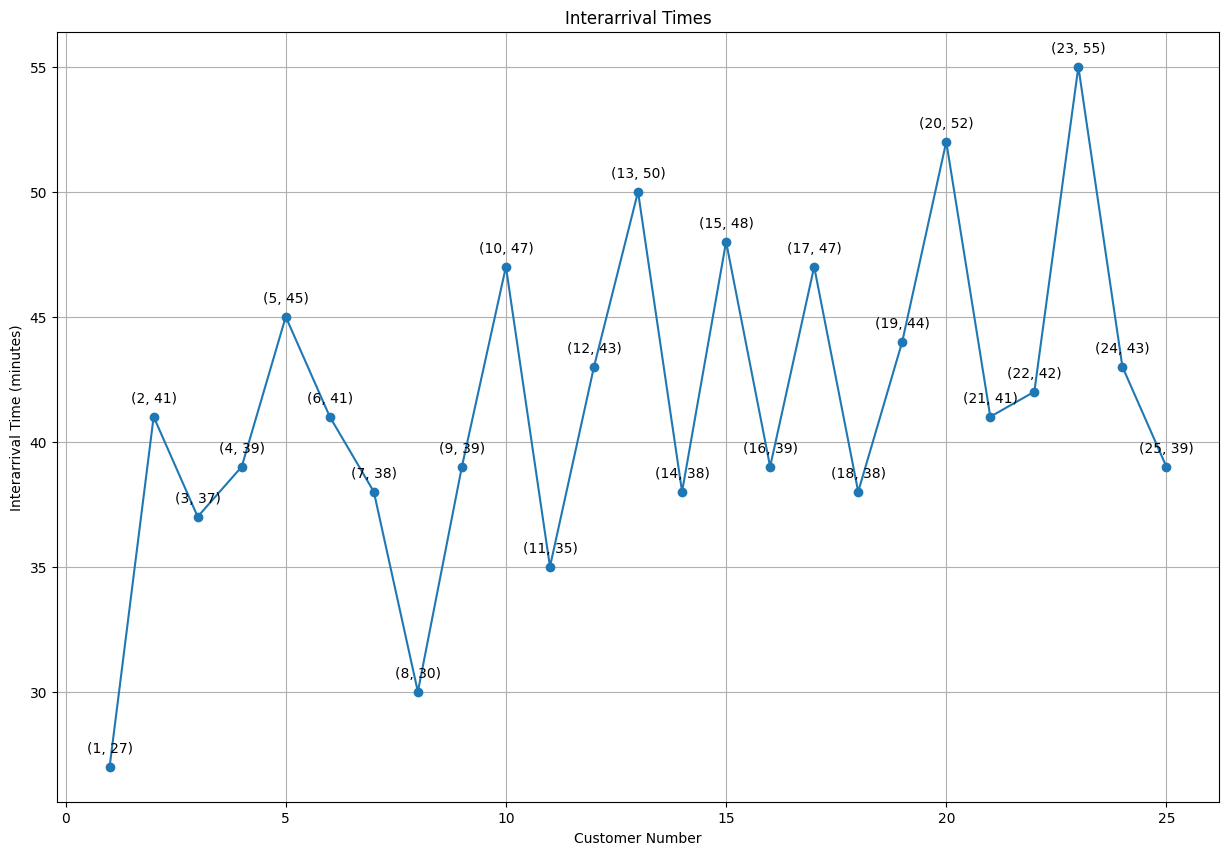

In [27]:
# Plotting Interarrival Times of Contract Customers (A_n)
x = list(range(1,len(A["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, A["contract"], label="Interarrival Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, A["contract"])):
    plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Interarrival Times")
plt.xlabel("Customer Number")
plt.ylabel("Interarrival Time (minutes)")
plt.show()




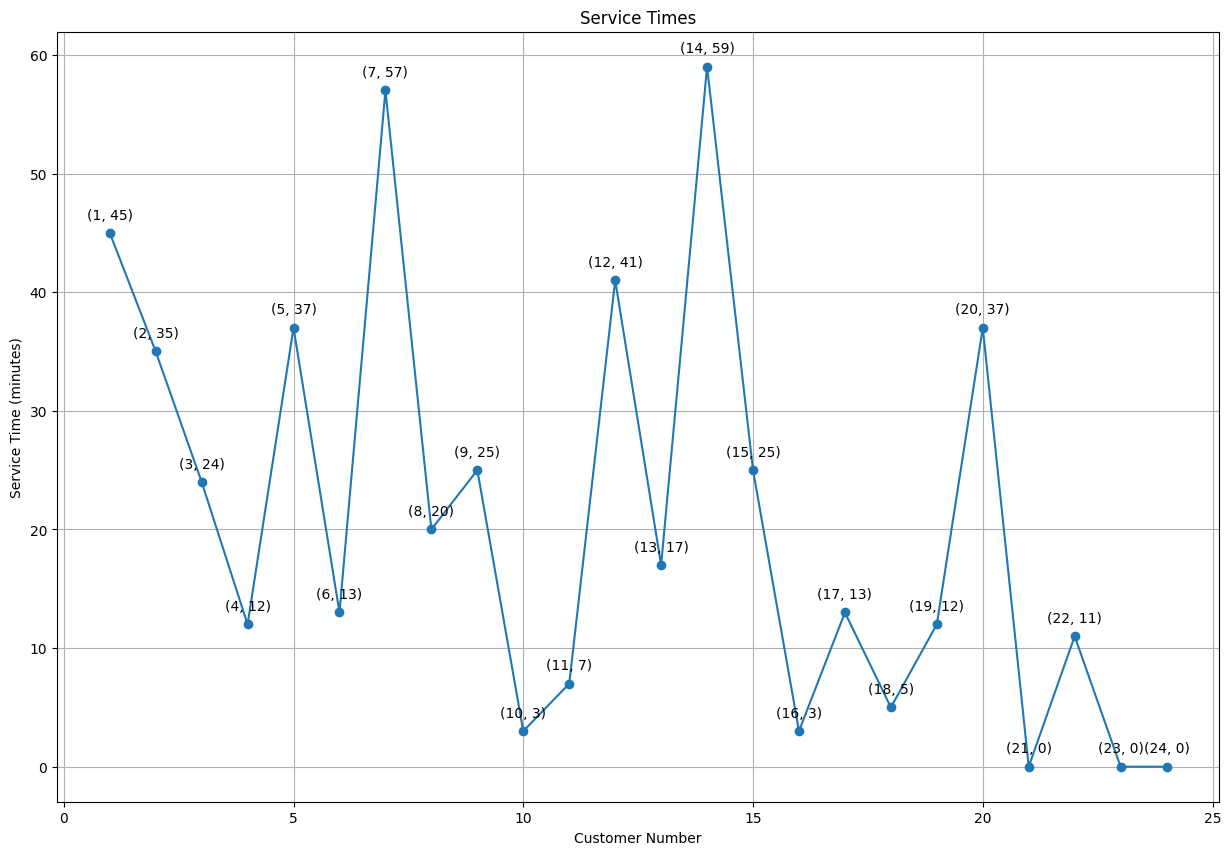

In [28]:
# Plotting Service Times of Contract Customers (S_n)
x = list(range(1,len(S["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, S["contract"], label="Service Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, S["contract"])):
    plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Service Times")
plt.xlabel("Customer Number")
plt.ylabel("Service Time (minutes)")
plt.show()


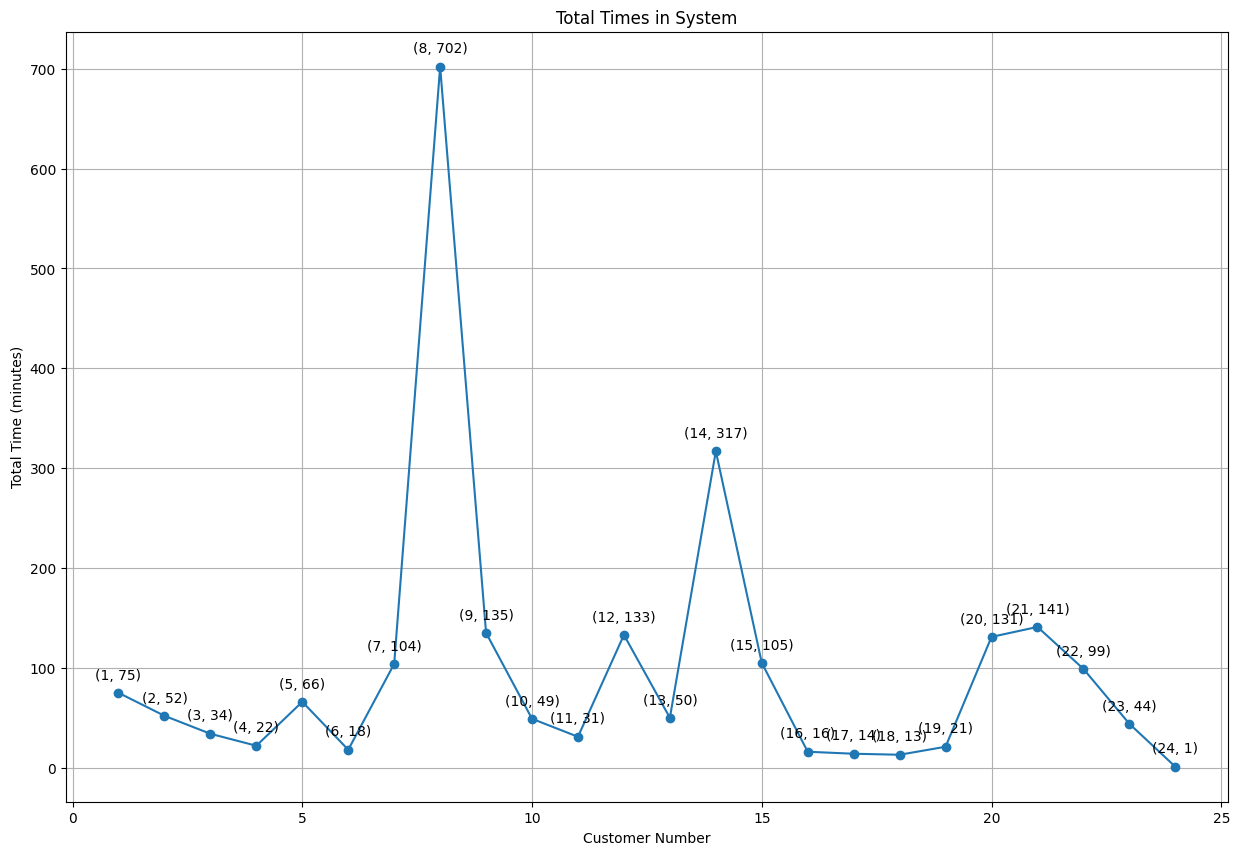

In [29]:
# Plotting Total Time each Contract Customer Spends in the System (W_n)
x = list(range(1,len(W["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, W["contract"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W["contract"])):
    plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in System")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()

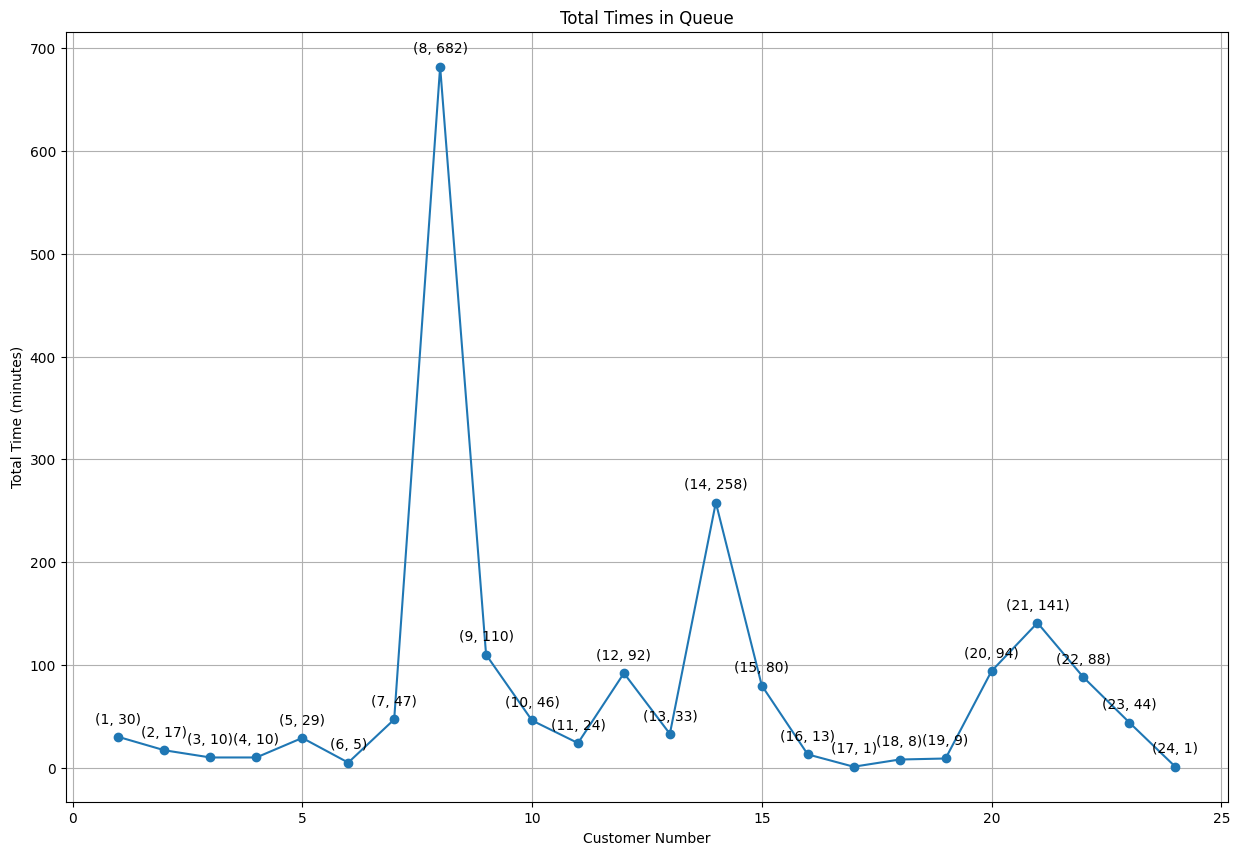

In [30]:
# Plotting Total Time each Contract Customer Spends in the Queue (W_Qn)
x = list(range(1,len(W_Q["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, W_Q["contract"], label="Total Times", marker='o', linestyle='-')

for i, (xi, yi) in enumerate(zip(x, W_Q["contract"])):
    plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Times in Queue")
plt.xlabel("Customer Number")
plt.ylabel("Total Time (minutes)")
plt.show()


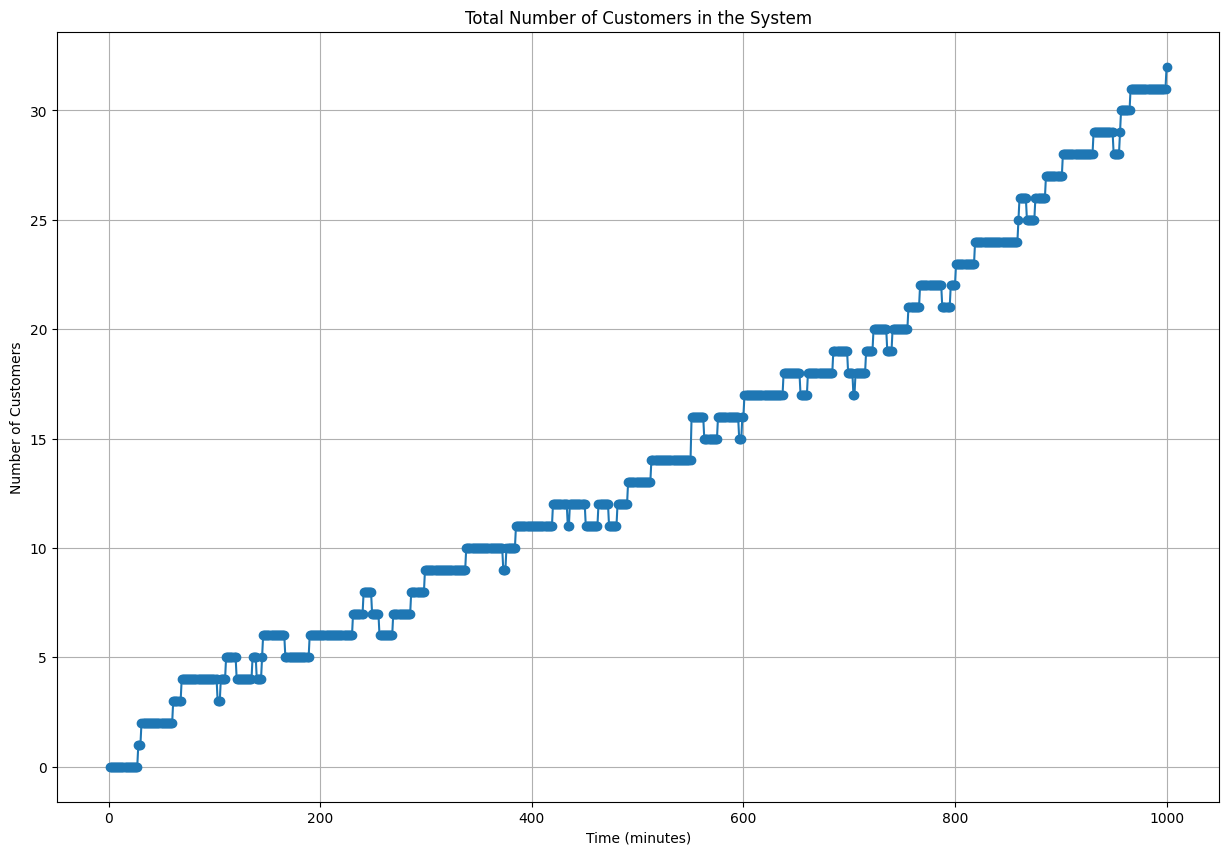

In [39]:
# Plotting Total Number of Customers in the System (L_n)
x = list(range(1,len(L["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L["contract"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L["contract"])):
    # plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the System")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers") 
plt.show()


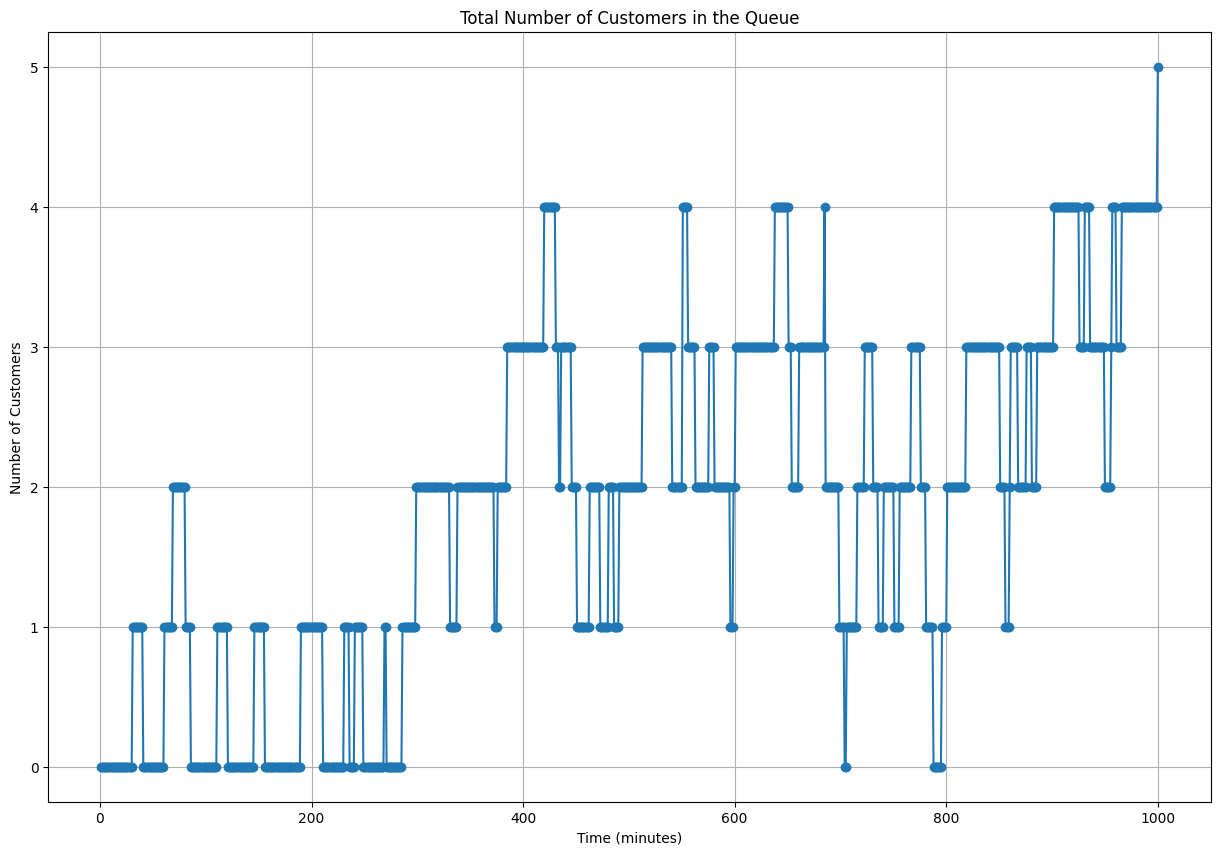

In [40]:
# Plotting Total Number of Customers in the Queue at Time n (L_Qn)
x = list(range(1,len(L_Q["contract"])+1))
plt.figure(figsize=(15, 10))
plt.plot(x, L_Q["contract"], label="Total Times", marker='o', linestyle='-')

# for i, (xi, yi) in enumerate(zip(x, L_Q["contract"])):
    # plt.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.title("Total Number of Customers in the Queue")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()

In [42]:
# Calculate the average number of customers in the system(L) and in the queue(L_Q), 
# and the average time spent in the system(W) and in the queue(W_Q) for each service type.

# Average Number of Customers in the System (L)
L_avg = np.mean(L["contract"])
print(f"Average Number of Customers in the System (L): {L_avg}")

# Average Number of Customers in the Queue (L_Q)
L_Q_avg = np.mean(L_Q["contract"])
print(f"Average Number of Customers in the Queue (L_Q): {L_Q_avg}")

# Average Time Spent in the System (W)
W_avg = np.mean(W["contract"])
print(f"Average Time Spent in the System (W): {W_avg}")

# Average Time Spent in the Queue (W_Q)
W_Q_avg = np.mean(W_Q["contract"])
print(f"Average Time Spent in the Queue (W_Q): {W_Q_avg}")



Average Number of Customers in the System (L): 14.223
Average Number of Customers in the Queue (L_Q): 1.872
Average Time Spent in the System (W): 98.875
Average Time Spent in the Queue (W_Q): 78.0


# Complain Service

# Confirm Service

# Request Service

# Review Service

Worker's Time Pie Chart

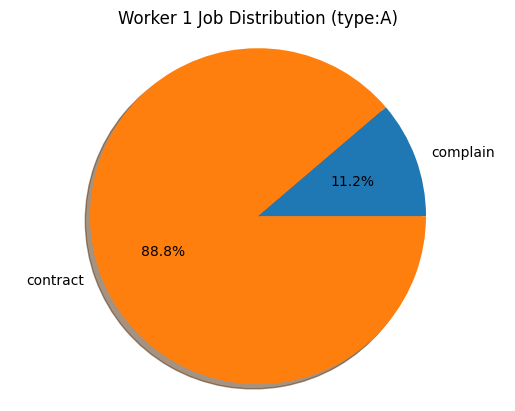

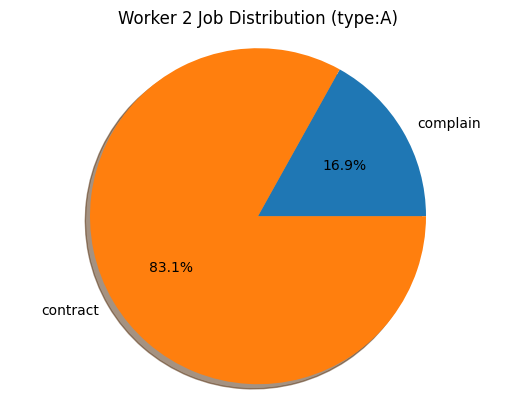

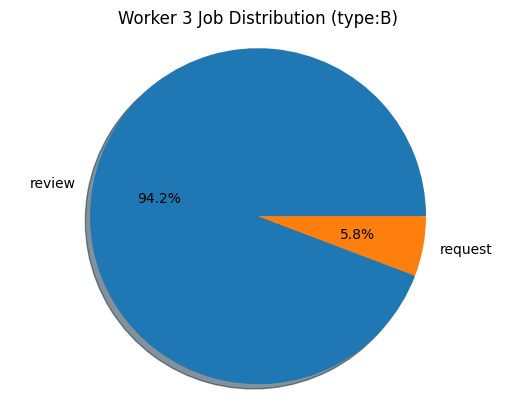

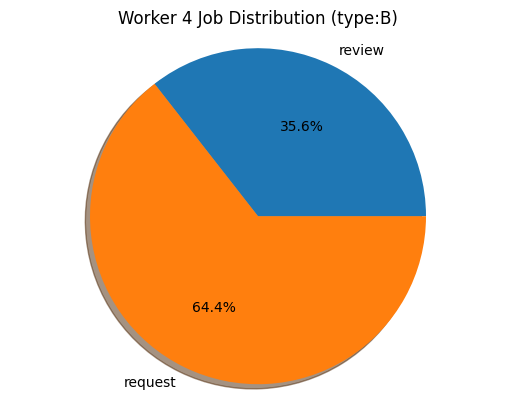

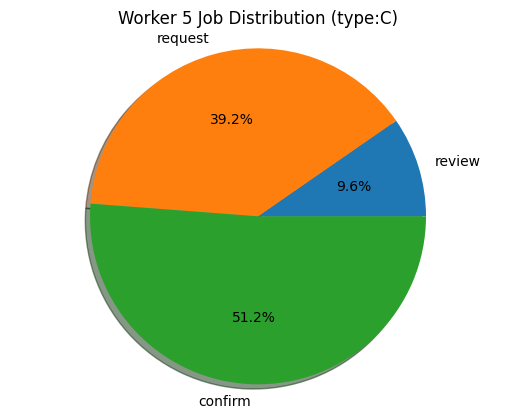

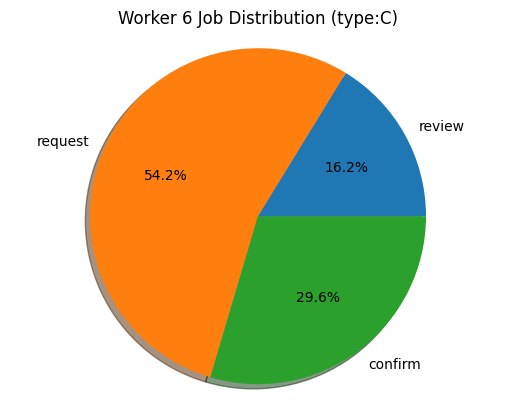

In [47]:
# draw pie chart for each worker of how much time they spent on each job
for i in range(len(workers_times)):
    worker = workers_times[i]
    labels = list(worker.keys())
    sizes = list(worker.values())
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
    ax1.axis('equal')
    plt.title(f"Worker {i+1} Job Distribution (type:{workers[i].type.name})")
    plt.show()